# Sloping Beach test case

The DG-CG code suffers from oscillations which appear to follow the orientation of the mesh. We will plot the cross-section elevation over time and see where the oscillation originates.

The current configuration is 7 cells wide, with numbering as follows:


| | | | | | |
|---|---|---|---|---|---|
| 2 | 72 | 142 | 212 | ... | 492 |
| 1  | 71 | 141 | 211 | ... | 491 |

In other words, the increment is 70 along a row, and 1 along a column.

To generate this mesh, run

    python slopingbeach.py 10000 fort.14

and then rename `fort.14.15` to `fort.15`.

## Extracting data from fort.63


In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# %matplotlib widget


row = 2
col = 211
NP = 560 # no. of nodes
N = 8 # no. of nodes in the x-direction
M = 70 # no. of nodes in the y-direction
cross_nodes = [row + M*i for i in range(0,N)]
y_nodes = [col + i for i in range(M)]


def read_63(fname, nodes):
    df = pd.read_csv(fname, skiprows=2, delim_whitespace=True, index_col=False, header=None, names=list('abc'))
    # drop the timestamps
    ts = list(filter(lambda x: (x % (NP+1) == 0), range(df.shape[0])))
    df = df.drop(ts)
    df.iloc[:,0] = df.iloc[:,0].astype(int)
    cross_elev = df.loc[df.iloc[:,0].isin(nodes)]
    cross_elev.iloc[:,0] = cross_elev.iloc[:,0].astype(int)
    return cross_elev.iloc[:,1].values


elev_adg = read_63('Beach/fort.63.coupling', cross_nodes)
elev_adc = read_63('Beach/fort.63.adc', cross_nodes)
u_adg = read_63('Beach/fort.64.coupling', cross_nodes)
u_adc = read_63('Beach/fort.64.adc', cross_nodes)

y_adg = read_63('Beach/fort.63.coupling', y_nodes)
y_adc = read_63('Beach/fort.63.adc', y_nodes)


In [64]:
df = pd.read_csv('Beach/fort.63.coupling', skiprows=2, delim_whitespace=True, index_col=False, header=None, names=list('abc'))
df.iloc[NP,:]

a    560.0
b      0.0
c      NaN
Name: 560, dtype: float64

In [65]:
ts = list(filter(lambda x: (x % (NP+1) == 0), range(df.shape[0])))
df = df.drop(ts)
df

,a,b,c
1,1.0,7.353913e-02,NaN
2,2.0,2.465178e-02,NaN
3,3.0,0.000000e+00,NaN
4,4.0,0.000000e+00,NaN
5,5.0,0.000000e+00,NaN
...,...,...,...
56095,556.0,4.063393e-79,NaN
56096,557.0,4.094753e-81,NaN
56097,558.0,3.907707e-83,NaN
56098,559.0,3.528034e-85,NaN


In [66]:
df.iloc[NP,:]

a    1.00000
b    0.13412
c        NaN
Name: 562, dtype: float64

In [67]:
cross_elev = df.loc[df.iloc[:,0].isin(y_nodes)]
cross_elev.iloc[:,0] = cross_elev.iloc[:,0].astype(int)

In [69]:
cross_elev.iloc[70,:]

a    71.000000
b     0.091992
c          NaN
Name: 632, dtype: float64

## Animation

### Player Class

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import mpl_toolkits.axes_grid1
import matplotlib.widgets

class Player(FuncAnimation):
    def __init__(self, fig, func, frames=None, init_func=None, fargs=None,
                 save_count=None, mini=0, maxi=100, pos=(0.125, 0.92), **kwargs):
        self.i = 0
        self.min=mini
        self.max=maxi
        self.runs = True
        self.forwards = True
        self.fig = fig
        self.func = func
        self.setup(pos)
        FuncAnimation.__init__(self,self.fig, self.update, frames=self.play(), 
                                           init_func=init_func, fargs=fargs,
                                           save_count=save_count, **kwargs )    

    def play(self):
        while self.runs:
            self.i = self.i+self.forwards-(not self.forwards)
            if self.i > self.min and self.i < self.max:
                yield self.i
            else:
                self.stop()
                yield self.i

    def start(self):
        self.runs=True
        self.event_source.start()

    def stop(self, event=None):
        self.runs = False
        self.event_source.stop()

    def forward(self, event=None):
        self.forwards = True
        self.start()
    def backward(self, event=None):
        self.forwards = False
        self.start()
    def oneforward(self, event=None):
        self.forwards = True
        self.onestep()
    def onebackward(self, event=None):
        self.forwards = False
        self.onestep()

    def onestep(self):
        if self.i > self.min and self.i < self.max:
            self.i = self.i+self.forwards-(not self.forwards)
        elif self.i == self.min and self.forwards:
            self.i+=1
        elif self.i == self.max and not self.forwards:
            self.i-=1
        self.func(self.i)
        self.slider.set_val(self.i)
        self.fig.canvas.draw_idle()

    def setup(self, pos):
        playerax = self.fig.add_axes([pos[0],pos[1], 0.64, 0.04])
        divider = mpl_toolkits.axes_grid1.make_axes_locatable(playerax)
        bax = divider.append_axes("right", size="80%", pad=0.05)
        sax = divider.append_axes("right", size="80%", pad=0.05)
        fax = divider.append_axes("right", size="80%", pad=0.05)
        ofax = divider.append_axes("right", size="100%", pad=0.05)
        sliderax = divider.append_axes("right", size="500%", pad=0.07)
        self.button_oneback = matplotlib.widgets.Button(playerax, label='$\u29CF$')
        self.button_back = matplotlib.widgets.Button(bax, label='$\u25C0$')
        self.button_stop = matplotlib.widgets.Button(sax, label='$\u25A0$')
        self.button_forward = matplotlib.widgets.Button(fax, label='$\u25B6$')
        self.button_oneforward = matplotlib.widgets.Button(ofax, label='$\u29D0$')
        self.button_oneback.on_clicked(self.onebackward)
        self.button_back.on_clicked(self.backward)
        self.button_stop.on_clicked(self.stop)
        self.button_forward.on_clicked(self.forward)
        self.button_oneforward.on_clicked(self.oneforward)
        self.slider = matplotlib.widgets.Slider(sliderax, '', 
                                                self.min, self.max, valinit=self.i)
        self.slider.on_changed(self.set_pos)

    def set_pos(self,i):
        self.i = int(self.slider.val)
        self.func(self.i)

    def update(self,i):
        self.slider.set_val(i)



### Animating the sloping beach - Horizontal profile

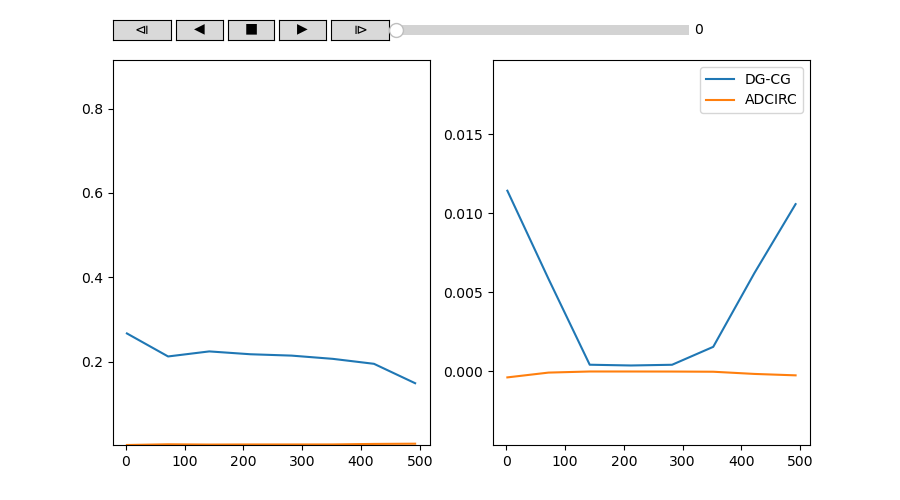

In [76]:

frame = 0
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,5))
line1, = ax1.plot(cross_nodes, elev_adg[frame*8:8*(frame+1)], label='DG-CG')
line2, = ax2.plot(cross_nodes, u_adg[frame*8:8*(frame+1)], label='DG-CG')
line11, = ax1.plot(cross_nodes, elev_adc[frame*8:8*(frame+1)], label='ADCIRC')
line21, = ax2.plot(cross_nodes, u_adc[frame*8:8*(frame+1)], label='ADCIRC')

plt.legend()

ax1.set_ylim(min(elev_adc), max(elev_adc))
ax2.set_ylim(min(u_adg), max(u_adg))


def update(frame):
    #ax.set_ylim(min(y), max(y))
    line1.set_ydata(elev_adg[frame*8:frame*8+8])
    line2.set_ydata(u_adg[frame*8:frame*8+8])
    line11.set_ydata(elev_adc[frame*8:frame*8+8])
    line21.set_ydata(u_adc[frame*8:frame*8+8])

    return line

ani = Player(fig, update, maxi=200, interval=100)

#ani = animation.FuncAnimation(fig=fig, func=update, frames=1, interval=30, repeat=False)
plt.show()

### Vertical profile

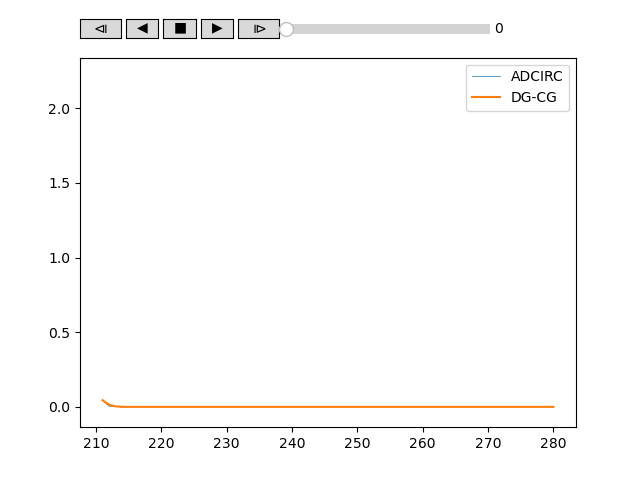

In [80]:

frame = 0
fig, ax1 = plt.subplots()
line11, = ax1.plot(y_nodes, y_adc[frame*M:M*(frame+1)], label='ADCIRC', linewidth=0.5)
line1, = ax1.plot(y_nodes, y_adg[frame*M:M*(frame+1)], label='DG-CG')

plt.legend()

ax1.set_ylim(min(y_adc), max(y_adc)+.5)


def update(frame):
    #ax.set_ylim(min(y), max(y))
    line1.set_ydata(y_adg[frame*M:frame*M+M])
    line11.set_ydata(y_adc[frame*M:frame*M+M])

    return line

ani = Player(fig, update, maxi=200, interval=100)

#ani = animation.FuncAnimation(fig=fig, func=update, frames=1, interval=30, repeat=False)
plt.show()

### Plotting function

In [100]:
from ipywidgets import interact
import ipywidgets as widgets
%matplotlib inline

def make_plot_function():

    def f(frame=0):
        fig, ax1 = plt.subplots()
        ax1.set_ylim(min(y_adc), max(y_adc)+.1)

        line11, = ax1.plot(y_nodes, y_adc[frame*M:M*(frame+1)], label='ADCIRC', linewidth=0.5)
        #line1, = ax1.plot(y_nodes, y_adg[frame*M:M*(frame+1)], label='DG-CG')

        plt.xlabel('Node')
        plt.ylabel('Water elevation (m)')
        plt.title('Sloping beach: y-direction profile')

        plt.legend()
        plt.show()
        
    return f

interact(make_plot_function(), frame=widgets.IntSlider(min=0, max=int(len(y_adc)/len(y_nodes))-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='frame', max=539), Output()), _dom_classes=('widget-inter…

<function __main__.make_plot_function.<locals>.f(frame=0)>

In [74]:
y_adg[-1]

7.811847271e-83